# Тестовое задание на позицию ML-разработчика

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,f1_score, make_scorer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [12]:
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
try:
    df = pd.read_csv(TRAIN_FILE)
    tdf = pd.read_csv(TEST_FILE)
    print(f"Data loaded, shape: {df.shape}, example: \n{df.iloc[5]}")
except FileNotFoundError:
    print(f"Ошибка: Файл 'test.csv' или 'train.csv' не найден. Убедитесь, что он в нужной папке.")

Data loaded, shape: (44400, 15), example: 
Name                               MR. Anthony mArTIn
Age                                              77.0
Gender                                           Male
Blood Type                                         O-
Medical Condition                           Arthritis
Date of Admission                          2024-04-05
Doctor                                   Joseph Nolan
Hospital              and Rodriguez Alvarez Gonzalez,
Insurance Provider                           Medicare
Billing Amount                           45451.957103
Room Number                                     385.0
Admission Type                                 Urgent
Discharge Date                             2024-04-18
Medication                                  Ibuprofen
Test Results                                   Normal
Name: 5, dtype: object


## Подготовка данных
При обработке данных пустые текстовые значения заполняются unknow, численные заполняются нулями, а пустые даты заполняются датой 01.01.1900. Параллельно создаются бинарные столбцы пропусков, где сохраняется информация был ли столбец пустым. Таким образом данные заполняются и становятся пригодными к обработке, но при этом не теряются данные о том, какие поля были пропущены. Удаляются полностью дублирующиеся строки и добавляются поля "продолжительность лечения", так как продолжительность лечения может помочь в определении диагноза или стоимости лечения.

In [ ]:
def DataPrep(df):
    df['Name'] = df['Name'].str.lower()
    titles_to_remove = ['mr', 'mrs', 'dr', 'miss', 'ms', 'jr']
    pattern = r'\b(' + '|'.join(titles_to_remove) + r')\b\s*'
    df['Name'] = df['Name'].str.replace(pattern, '', regex=True)
    df['Name'] = df['Name'].str.replace(r'[^a-z\s]', '', regex=True)
    df['Name'] = df['Name'].str.strip()
    df['Name Missing'] = df['Name'].isnull().astype(int)
    df['Name'].fillna('unknown patient', inplace = True)
    
    df['Gender Missing'] = df['Gender'].isnull().astype(int)
    df['Gender'].fillna('unknown', inplace = True)
    
    df['Blood Type Missing'] = df['Gender'].isnull().astype(int)
    df['Blood Type'].fillna('unknown', inplace = True)
    
    df['Doctor Missing'] = df['Doctor'].isnull().astype(int)
    df['Doctor'].fillna('unknown doctor', inplace = True)
    
    df['Medical Condition Missing'] = df['Medical Condition'].isnull().astype(int)
    df['Medical Condition'].fillna('unknown', inplace = True)
    
    df['Hospital Missing'] = df['Hospital'].isnull().astype(int)
    df['Hospital'].fillna('unknown hospital', inplace = True)
    
    df['Insurance Provider Missing'] = df['Insurance Provider'].isnull().astype(int)
    df['Insurance Provider'].fillna('unknown', inplace = True)
    
    df['Admission Type Missing'] = df['Admission Type'].isnull().astype(int)
    df['Admission Type'].fillna('unknown', inplace = True)
    
    df['Medication Missing'] = df['Medication'].isnull().astype(int)
    df['Medication'].fillna('unknown', inplace = True)
    
    df['Test Results Missing'] = df['Test Results'].isnull().astype(int)
    df['Test Results'].fillna('unknown', inplace = True)
    
    text_columns = ['Gender', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower()
    
    df['Age Missing'] = df['Age'].isnull().astype(int)
    df['Age'].fillna(0, inplace = True)
    
    df['Date of Admission Missing'] = df['Date of Admission'].isnull().astype(int)
    df['Date of Admission'].fillna(datetime.datetime(1900,1,1), inplace = True)
    
    df['Billing Amount Missing'] = df['Billing Amount'].isnull().astype(int)
    df['Billing Amount'].fillna(0, inplace = True)
    
    df['Room Number Missing'] = df['Room Number'].isnull().astype(int)
    df['Room Number'].fillna(0, inplace = True)
    
    df['Discharge Date Missing'] =df['Discharge Date'].isnull().astype(int)
    df['Discharge Date'].fillna(datetime.datetime(1900,1,1), inplace = True)
    
    df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
    df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    initial_rows = len(df)
    
    df['Duration Of Treatment'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
    missing_los_mask = (df['Date of Admission'] == datetime.datetime(1900,1,1)) | (df['Discharge Date'] == datetime.datetime(1900,1,1))
    df.loc[missing_los_mask, 'Duration Of Treatment'] = 0
    return df
    
df = DataPrep(df)
tdf = DataPrep(tdf)
#print(tdf.iloc[5])

Name                               ethan mitchell
Age                                          46.0
Gender                                       male
Blood Type                                     B+
Medical Condition                          cancer
Date of Admission             2021-12-30 00:00:00
Doctor                             christina hart
Hospital                             rocha-wagner
Insurance Provider                       medicare
Billing Amount                        4802.620714
Room Number                                 175.0
Admission Type                           elective
Discharge Date                2022-01-27 00:00:00
Medication                            paracetamol
Test Results                             abnormal
Name Missing                                    0
Gender Missing                                  0
Blood Type Missing                              0
Doctor Missing                                  0
Medical Condition Missing                       0


## Отрисовка графиков
Тут отрисовываются основные графики распределения различных величин. 
Графики показывают:
1) Зависимость стоимости лечения от возраста пациента
2) Зависимость стоимости лечения от продолжительности лечения
3) Зависимость продолжительности лечения от возраста
4) Зависимость стоимости лечения от страховой компании
5) Зависимость медианы стоимости лечения от Страховой компании
6) Зависимость медианы стоимости лечения от препарата
7) Зависимость медианы стоимости лечения от заболевания
8) Зависимость медианы стоимости лечения от типа госпитализации
В последних 4ех графиках используется медиана вместо средней, так как она более устойчива к выбросам данных (например слишком высокие ии нулевые значения стоимости)

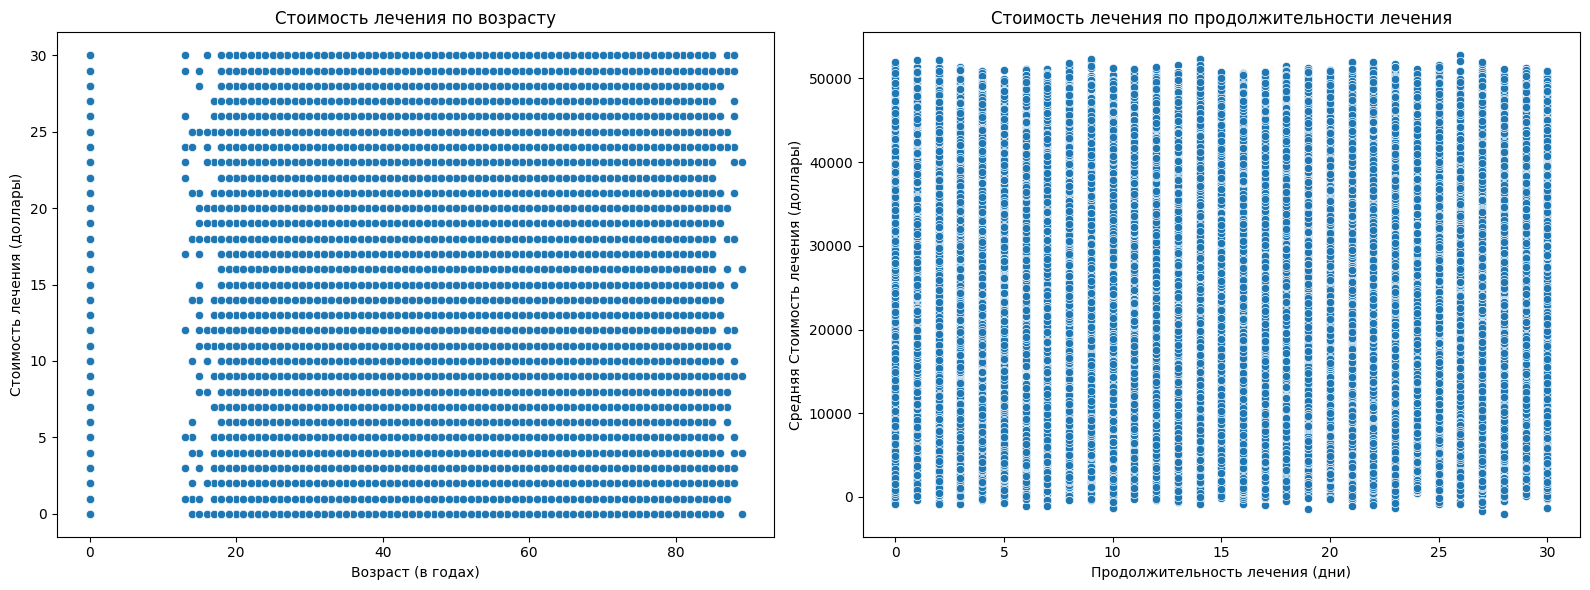

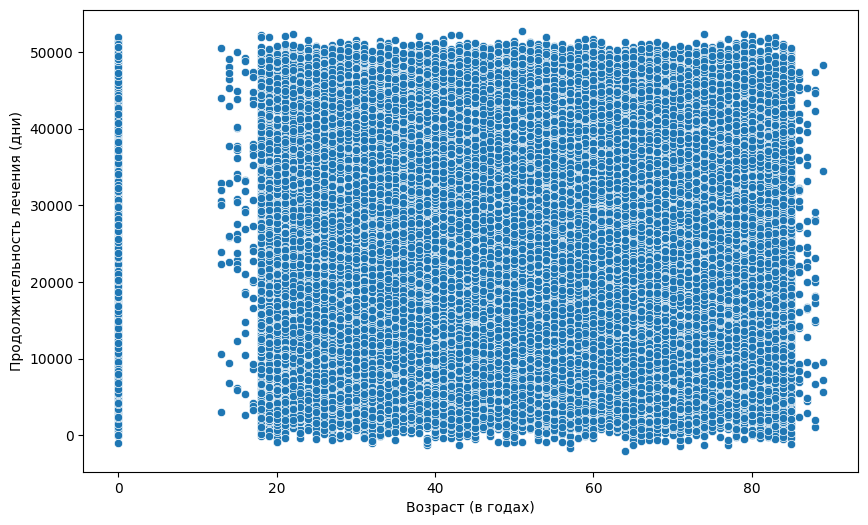

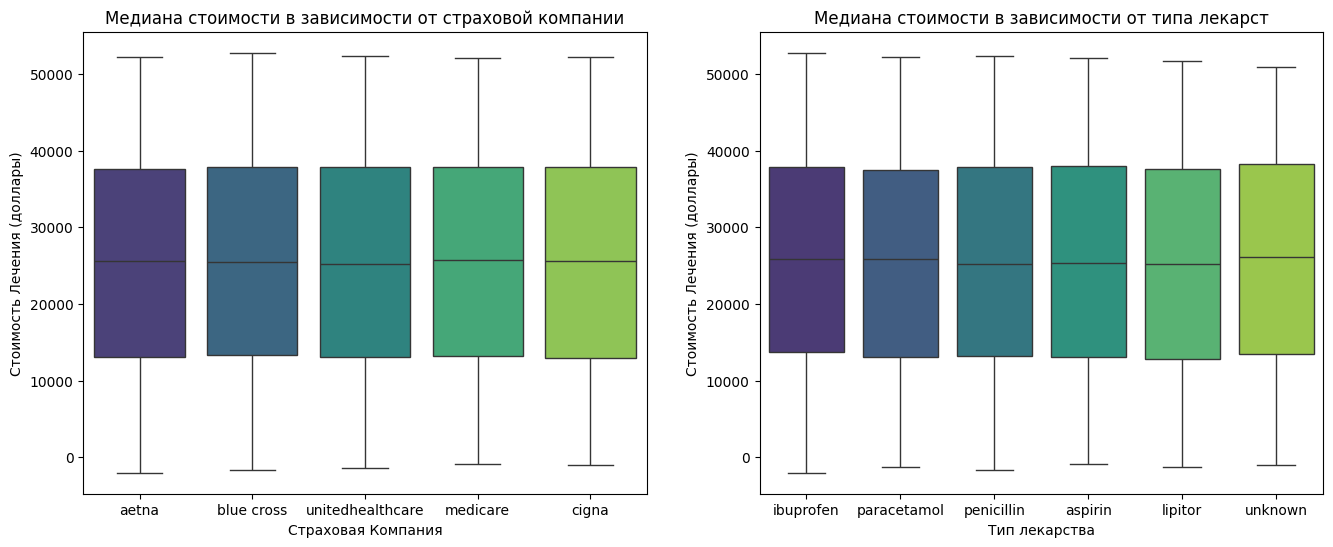

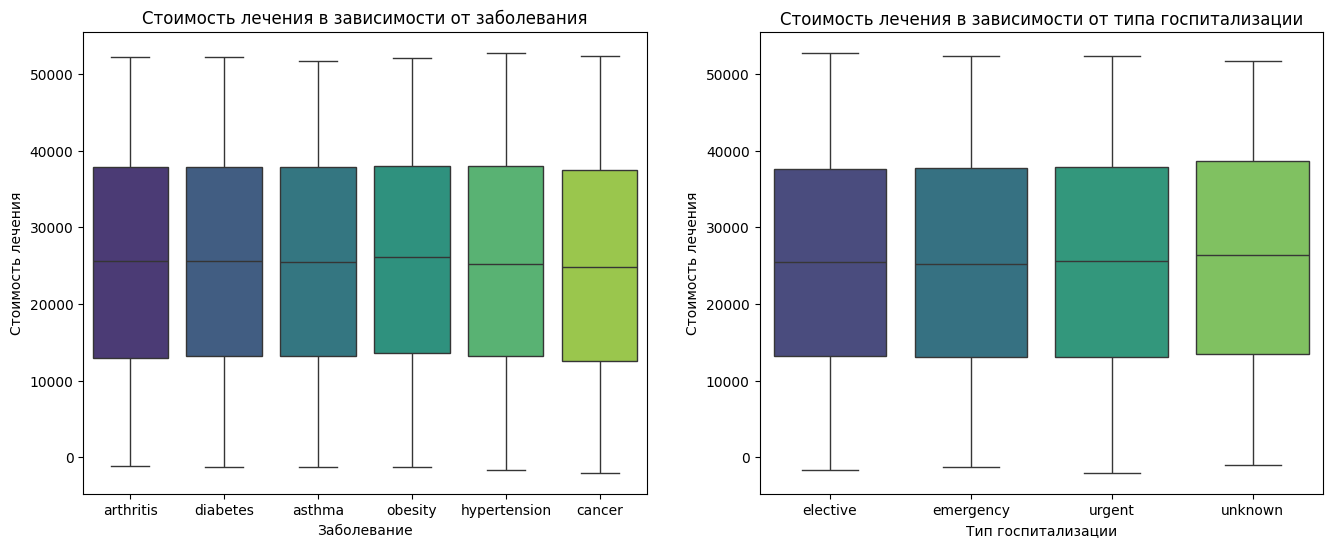

In [15]:

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.scatterplot(x="Age", y= 'Duration Of Treatment', data = df, ax = axes[0])
axes[0].set_title('Стоимость лечения по возрасту')
axes[0].set_xlabel('Возраст (в годах)')
axes[0].set_ylabel('Стоимость лечения (доллары)')

sns.scatterplot(
    x='Duration Of Treatment', 
    y='Billing Amount', 
    data=df,
    ax = axes[1]
)
axes[1].set_title('Стоимость лечения по продолжительности лечения')
axes[1].set_xlabel('Продолжительность лечения (дни)')
axes[1].set_ylabel('Средняя Стоимость лечения (доллары)')
plt.tight_layout() 
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'Age', y='Billing Amount', data = df)
plt.xlabel('Возраст (в годах)')
plt.ylabel('Продолжительность лечения (дни)')
plt.show()

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.boxplot(
    x='Insurance Provider', 
    y='Billing Amount', 
    data=df, 
    palette='viridis',
    ax = axes[0]
)
axes[0].set_title("Медиана стоимости в зависимости от страховой компании")
axes[0].set_xlabel('Страховая Компания')
axes[0].set_ylabel('Стоимость Лечения (доллары)')

sns.boxplot(
    x='Medication', 
    y='Billing Amount', 
    data=df, 
    palette='viridis',
    ax = axes[1]
)
axes[1].set_title("Медиана стоимости в зависимости от типа лекарст")
axes[1].set_xlabel('Тип лекарства')
axes[1].set_ylabel('Стоимость Лечения (доллары)')

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.boxplot(
    x='Medical Condition', 
    y='Billing Amount', 
    data=df, 
    palette='viridis',
    ax= axes[0]
)

axes[0].set_title('Стоимость лечения в зависимости от заболевания')
axes[0].set_xlabel('Заболевание')
axes[0].set_ylabel('Стоимость лечения')

sns.boxplot(
    x='Admission Type' , 
    y='Billing Amount', 
    data=df, 
    palette='viridis',
    ax= axes[1]
)

axes[1].set_title('Стоимость лечения в зависимости от типа госпитализации')
axes[1].set_xlabel('Тип госпитализации')
axes[1].set_ylabel('Стоимость лечения')
plt.show()


## Гипотезы
1) Гипотеза 1:
       Средняя стоимость лечения зависит от продолжительности лечения
2) Гипотеза 2:
       Средняя стоимость лечения зависит от возраста
3) Гипотеза 3:
       Средняя стоимость лечения зависит от заболевания

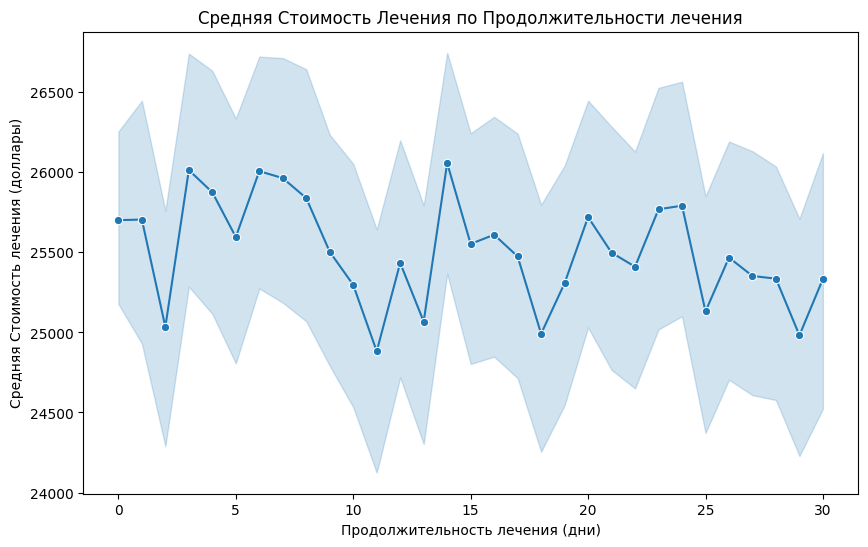


Коэффициент корреляции Пирсона (p): -0.0086


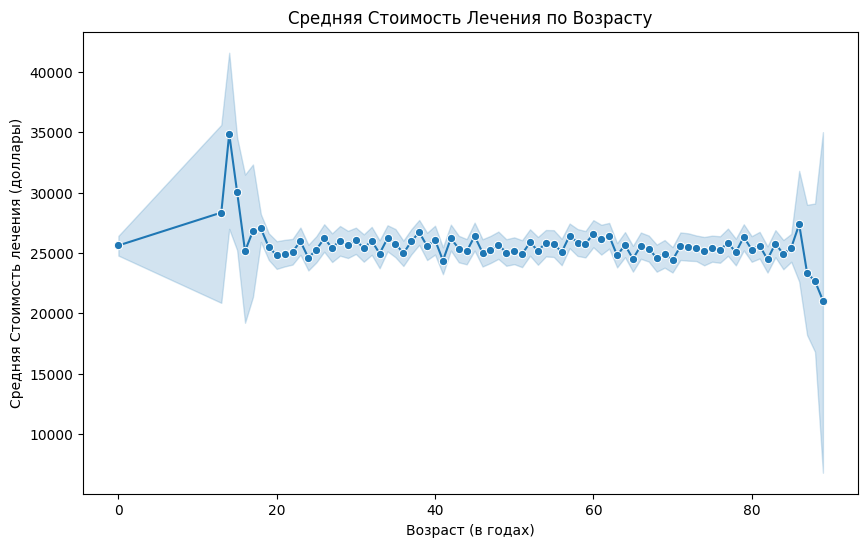


Коэффициент корреляции Пирсона (p): -0.0077


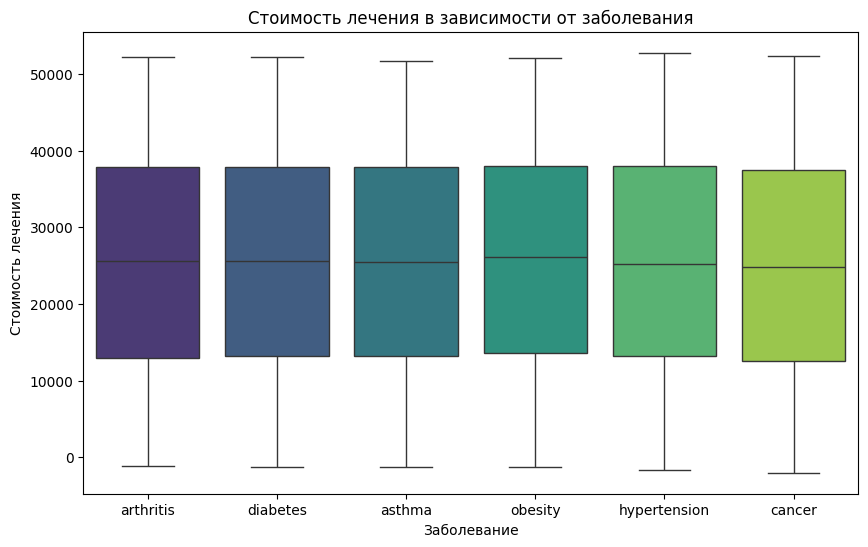

F-статистика: 1.9172
p-значение: 0.0879


In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Duration Of Treatment', 
    y='Billing Amount', 
    data=df, 
    estimator=np.mean,
    marker='o'
)

plt.title('Средняя Стоимость Лечения по Продолжительности лечения')
plt.xlabel('Продолжительность лечения (дни)')
plt.ylabel('Средняя Стоимость лечения (доллары)')
plt.show()

correlation, p_value = stats.pearsonr(df['Duration Of Treatment'], df['Billing Amount'])
print(f"\nКоэффициент корреляции Пирсона (p): {correlation:.4f}")

plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Age', 
    y='Billing Amount', 
    data=df, 
    estimator=np.mean,
    marker='o'
)

plt.title('Средняя Стоимость Лечения по Возрасту')
plt.xlabel('Возраст (в годах)')
plt.ylabel('Средняя Стоимость лечения (доллары)')
plt.show()

correlation, p_value = stats.pearsonr(df['Age'], df['Billing Amount'])
print(f"\nКоэффициент корреляции Пирсона (p): {correlation:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Medical Condition' , 
    y='Billing Amount', 
    data=df, 
    palette='viridis',
)
plt.title('Стоимость лечения в зависимости от заболевания')
plt.xlabel('Заболевание')
plt.ylabel('Стоимость лечения')
plt.show()

df_known_cond = df[df['Medical Condition'] != 'unknown']
unique_conditions = df_known_cond['Medical Condition'].unique()
billing_groups = [df_known_cond[df_known_cond['Medical Condition'] == cond]['Billing Amount'] for cond in unique_conditions]

f_statistic, p_value_anova = stats.f_oneway(*billing_groups)

print(f"F-статистика: {f_statistic:.4f}")
print(f"p-значение: {p_value_anova:.4f}")

### Результаты
Ни одна из трех теорий не подтверждается. Кроме того, исходя из отрисованных ранее восьми графиков видно, что зависимости между данными нет, данные сгенерированы случайно. Следовательно при обучении моделей будет наблюдаться их низкая предсказательная сила.

## Обучение моделей
### Обучение модели предсказания заболевания пациента
В качестве основной модели был выбран Random Forest так как он устойчив к выбросам и переобучению, он поддерживает категориальные (после обработки OHE) и численные данные. В качестве данных для обучения были выбраны следующие столбцы: Age','Gender','Blood Type','Insurance Provider','Billing Amount','Medication','Test Results','Duration Of Treatment'. Именно они должны нести больше всего информации о том, чем болеет человек. Также при обучении использован подбор гиперпараметров и кросс-валидация. В качестве метрики была выбрана метрика f1, т.к она отражает точность модели и то, сколько реальных объектов класса модель нашла.

In [18]:
print ("start of block")
TARGET = 'Medical Condition'
df_model = df[df[TARGET] != 'unknown'].copy()
tdf_model = tdf[tdf[TARGET] != 'unknown'].copy()

X = df_model[['Age','Gender','Blood Type','Insurance Provider','Billing Amount','Medication','Test Results','Duration Of Treatment']]
Y = df_model[TARGET]

X_test = tdf_model[['Age','Gender','Blood Type','Insurance Provider','Billing Amount','Medication','Test Results','Duration Of Treatment']]
Y_test = tdf_model[TARGET]

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
preprocessor = ColumnTransformer(transformers = [('cat',OneHotEncoder(handle_unknown = 'ignore'), categorical_features),('num','passthrough', numerical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=1337, n_estimators=200, class_weight='balanced'))])
f1_scorer = make_scorer(f1_score, average='macro', pos_label=None)
param_grid = {'classifier__n_estimators': [100, 300], 'classifier__max_depth': [20, 30], 'classifier__min_samples_leaf': [1, 5]}

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
)


grid_search.fit(X, Y)

best_f1_cv = grid_search.best_score_
final_f1_test = f1_score(Y_test, grid_search.best_estimator_.predict(X_test), average='macro')

print(f"Лучшие гиперпараметры: {grid_search.best_params_}")
print(f"Средний F1-score на кросс-валидации: {best_f1_cv:.4f}")
print(f"Финальный F1-score на тестовой выборке: {final_f1_test:.4f}")

start of block
Лучшие гиперпараметры: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
Средний F1-score на кросс-валидации: 0.2401
Финальный F1-score на тестовой выборке: 0.2590


### Обучение модели предсказания заболевания пациента
В качестве основной модели был выбран XGBoost, он также как Random Forest устойчив к переобучению, но к тому же работает быстрее на больших наборах данных. При обучении использован подбор гиперпараметров и кросс-валидация. В качестве метрики была выбрана средняя абсолютная ошибка (MAE), т.к она более устойчива и меньше наказывает модель, чем среднеквадратичная (MSE).

In [ ]:
TARGET = 'Billing Amount'
df_model = df[df[TARGET] != 0].copy()
tdf_model = tdf[tdf[TARGET] != 0].copy()
X = df_model[['Age','Gender','Blood Type','Medical Condition','Insurance Provider','Medication','Test Results','Duration Of Treatment']]
Y = df_model[TARGET]

X_test = tdf_model[['Age','Gender','Blood Type','Medical Condition','Insurance Provider','Medication','Test Results','Duration Of Treatment']]
Y_test = tdf_model[TARGET]

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
preprocessor = ColumnTransformer(transformers = [('cat',OneHotEncoder(handle_unknown = 'ignore'), categorical_features),('num','passthrough', numerical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', xgb.XGBRegressor(random_state=1337, n_estimators=300, learning_rate=0.005, n_jobs = -1))])

param_grid = {'regressor__n_estimators': [100, 200, 300], 'regressor__learning_rate': [0.03,0.04, 0.05]}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1,
)
grid_search.fit(X, Y)

best_params = grid_search.best_params_
best_mae_cv = -grid_search.best_score_
final_mae_test = mean_absolute_error(Y_test, grid_search.best_estimator_.predict(X_test))

print(f"Лучшие гиперпараметры: {best_params}")
print(f"Средняя MAE на кросс-валидации: {best_mae_cv:.2f} USD")
print(f"Финальная MAE на тестовой выборке: {final_mae_test:.2f} USD")

Лучшие гиперпараметры: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 100}
Средняя MAE на кросс-валидации: 12328.60 USD
Финальная MAE на тестовой выборке: 12205.42 USD


## Результаты 
Был исследован набор данных о лечении пациентов. Было выявлено, что данные в датасете не имеют корелляции между собой. Были обучены две модели (для предсказания заболевания и стоимости лечения) для первой модели конечная метрика составила f1 = 0.2590, а для второй MAE = 12205.42. Обе модели имеют слабую предсказательную силу в следствие того, что явной корелляции между данными не существует.